#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN() # initialise model

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=get_mean_rgb(datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor())), std=[1,1,1])
])

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Specify hyperparameters

In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [6]:
lr = 0.001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function

if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model.to(device)

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=10) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model/non_preprocessed"
if not os.path.exists(baseline_model_path):
    os.makedirs(baseline_model_path, exist_ok=True)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

Train the model

In [7]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300: 100%|███████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=4.4071]


Epoch 1/300 took 32.85s | Train loss: 4.4071 | Val loss: 4.8872 | Val accuracy: 1.47% | EarlyStopper count: 0


Epoch 2/300: 100%|███████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=4.2235]


Epoch 2/300 took 32.55s | Train loss: 4.2235 | Val loss: 4.4365 | Val accuracy: 2.45% | EarlyStopper count: 0


Epoch 3/300: 100%|███████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=3.9741]


Epoch 3/300 took 32.89s | Train loss: 3.9741 | Val loss: 4.3988 | Val accuracy: 2.16% | EarlyStopper count: 0


Epoch 4/300: 100%|███████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=3.8225]


Epoch 4/300 took 32.77s | Train loss: 3.8225 | Val loss: 4.0739 | Val accuracy: 4.71% | EarlyStopper count: 0


Epoch 5/300: 100%|███████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=3.6505]


Epoch 5/300 took 33.98s | Train loss: 3.6505 | Val loss: 3.9519 | Val accuracy: 6.08% | EarlyStopper count: 0


Epoch 6/300: 100%|███████████████████████████████████████████████| 49/49 [00:32<00:00,  1.51it/s, Training loss=3.5205]


Epoch 6/300 took 36.43s | Train loss: 3.5205 | Val loss: 3.8220 | Val accuracy: 6.37% | EarlyStopper count: 0


Epoch 7/300: 100%|███████████████████████████████████████████████| 49/49 [00:30<00:00,  1.59it/s, Training loss=3.3873]


Epoch 7/300 took 34.55s | Train loss: 3.3873 | Val loss: 3.6686 | Val accuracy: 9.61% | EarlyStopper count: 0


Epoch 8/300: 100%|███████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=3.2680]


Epoch 8/300 took 33.56s | Train loss: 3.2680 | Val loss: 3.5399 | Val accuracy: 11.08% | EarlyStopper count: 0


Epoch 9/300: 100%|███████████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s, Training loss=3.1698]


Epoch 9/300 took 33.99s | Train loss: 3.1698 | Val loss: 3.5315 | Val accuracy: 12.25% | EarlyStopper count: 0


Epoch 10/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=3.0639]


Epoch 10/300 took 33.59s | Train loss: 3.0639 | Val loss: 3.2648 | Val accuracy: 14.80% | EarlyStopper count: 0


Epoch 11/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=2.9686]


Epoch 11/300 took 33.43s | Train loss: 2.9686 | Val loss: 3.4238 | Val accuracy: 14.41% | EarlyStopper count: 0


Epoch 12/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=2.9292]


Epoch 12/300 took 33.64s | Train loss: 2.9292 | Val loss: 3.1642 | Val accuracy: 18.53% | EarlyStopper count: 1


Epoch 13/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=2.8115]


Epoch 13/300 took 33.56s | Train loss: 2.8115 | Val loss: 3.0704 | Val accuracy: 18.53% | EarlyStopper count: 0


Epoch 14/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=2.6965]


Epoch 14/300 took 33.15s | Train loss: 2.6965 | Val loss: 2.9926 | Val accuracy: 21.47% | EarlyStopper count: 0


Epoch 15/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=2.6763]


Epoch 15/300 took 33.45s | Train loss: 2.6763 | Val loss: 2.8939 | Val accuracy: 22.35% | EarlyStopper count: 0


Epoch 16/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=2.5480]


Epoch 16/300 took 33.41s | Train loss: 2.5480 | Val loss: 2.8883 | Val accuracy: 23.63% | EarlyStopper count: 0


Epoch 17/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=2.5086]


Epoch 17/300 took 33.20s | Train loss: 2.5086 | Val loss: 2.8328 | Val accuracy: 25.78% | EarlyStopper count: 0


Epoch 18/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=2.4255]


Epoch 18/300 took 33.23s | Train loss: 2.4255 | Val loss: 2.8238 | Val accuracy: 25.69% | EarlyStopper count: 0


Epoch 19/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=2.3498]


Epoch 19/300 took 33.68s | Train loss: 2.3498 | Val loss: 2.7759 | Val accuracy: 26.57% | EarlyStopper count: 0


Epoch 20/300: 100%|██████████████████████████████████████████████| 49/49 [00:30<00:00,  1.63it/s, Training loss=2.3405]


Epoch 20/300 took 33.83s | Train loss: 2.3405 | Val loss: 2.8072 | Val accuracy: 27.25% | EarlyStopper count: 0


Epoch 21/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=2.2289]


Epoch 21/300 took 33.48s | Train loss: 2.2289 | Val loss: 2.6689 | Val accuracy: 30.69% | EarlyStopper count: 1


Epoch 22/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=2.1182]


Epoch 22/300 took 33.49s | Train loss: 2.1182 | Val loss: 2.6254 | Val accuracy: 29.71% | EarlyStopper count: 0


Epoch 23/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.9806]


Epoch 23/300 took 33.41s | Train loss: 1.9806 | Val loss: 2.5245 | Val accuracy: 33.33% | EarlyStopper count: 0


Epoch 24/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.9637]


Epoch 24/300 took 33.06s | Train loss: 1.9637 | Val loss: 2.6668 | Val accuracy: 29.80% | EarlyStopper count: 0


Epoch 25/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=1.9763]


Epoch 25/300 took 33.73s | Train loss: 1.9763 | Val loss: 2.4776 | Val accuracy: 35.98% | EarlyStopper count: 1


Epoch 26/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.8252]


Epoch 26/300 took 33.46s | Train loss: 1.8252 | Val loss: 2.5344 | Val accuracy: 35.98% | EarlyStopper count: 0


Epoch 27/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.7363]


Epoch 27/300 took 33.52s | Train loss: 1.7363 | Val loss: 2.4485 | Val accuracy: 36.76% | EarlyStopper count: 1


Epoch 28/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s, Training loss=1.6376]


Epoch 28/300 took 33.64s | Train loss: 1.6376 | Val loss: 2.5508 | Val accuracy: 36.37% | EarlyStopper count: 0


Epoch 29/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.5580]


Epoch 29/300 took 33.52s | Train loss: 1.5580 | Val loss: 2.4100 | Val accuracy: 39.71% | EarlyStopper count: 1


Epoch 30/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.4498]


Epoch 30/300 took 33.48s | Train loss: 1.4498 | Val loss: 2.3732 | Val accuracy: 38.14% | EarlyStopper count: 0


Epoch 31/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.3755]


Epoch 31/300 took 32.89s | Train loss: 1.3755 | Val loss: 2.3078 | Val accuracy: 41.76% | EarlyStopper count: 0


Epoch 32/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.3658]


Epoch 32/300 took 33.13s | Train loss: 1.3658 | Val loss: 2.3542 | Val accuracy: 41.18% | EarlyStopper count: 0


Epoch 33/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.2682]


Epoch 33/300 took 32.88s | Train loss: 1.2682 | Val loss: 2.4079 | Val accuracy: 41.27% | EarlyStopper count: 1


Epoch 34/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=1.2501]


Epoch 34/300 took 33.15s | Train loss: 1.2501 | Val loss: 2.3393 | Val accuracy: 41.86% | EarlyStopper count: 2


Epoch 35/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=1.0734]


Epoch 35/300 took 33.14s | Train loss: 1.0734 | Val loss: 2.5340 | Val accuracy: 39.31% | EarlyStopper count: 3


Epoch 36/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=1.0817]


Epoch 36/300 took 33.42s | Train loss: 1.0817 | Val loss: 2.4282 | Val accuracy: 41.67% | EarlyStopper count: 4


Epoch 37/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=1.1433]


Epoch 37/300 took 33.26s | Train loss: 1.1433 | Val loss: 2.5233 | Val accuracy: 42.16% | EarlyStopper count: 5


Epoch 38/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=1.1895]


Epoch 38/300 took 33.22s | Train loss: 1.1895 | Val loss: 2.5066 | Val accuracy: 43.33% | EarlyStopper count: 6


Epoch 39/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s, Training loss=0.9445]


Epoch 39/300 took 33.48s | Train loss: 0.9445 | Val loss: 2.4733 | Val accuracy: 42.35% | EarlyStopper count: 7


Epoch 40/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s, Training loss=0.8095]


Epoch 40/300 took 33.18s | Train loss: 0.8095 | Val loss: 2.4936 | Val accuracy: 42.16% | EarlyStopper count: 8


Epoch 41/300: 100%|██████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=0.9203]


Epoch 41/300 took 33.21s | Train loss: 0.9203 | Val loss: 2.5651 | Val accuracy: 43.24% | EarlyStopper count: 9
Early stopping


Plot train, test loss and test accuracy

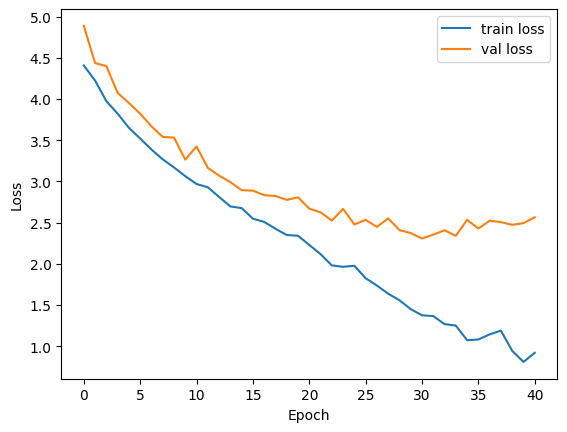

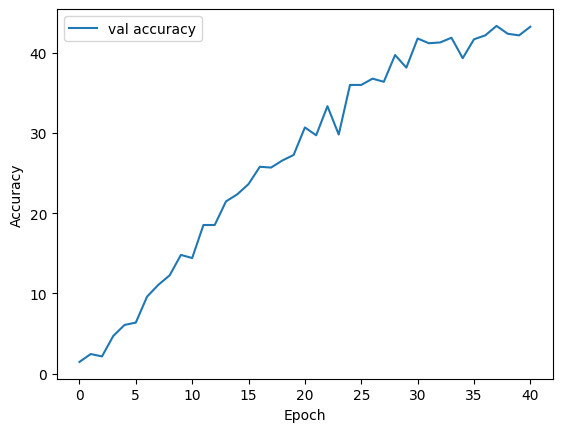

In [8]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()